In [70]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [71]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pickle
import json
import h5py


cuda = torch.device('cuda')
frame_size = 10
movie_ref = pickle.load(open('../data/infos_pca128.pytorch', 'rb'))
# on my system os error often pops up
# try to open the file explorer and copy paste the path again 
f = h5py.File("../data/static_ml20m.hdf5", "r")

In [72]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

# https://github.com/LiyuanLucasLiu/RAdam

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

In [73]:
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-1):
        super(Actor, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        # state = self.state_rep(state)
        x = F.relu(self.linear1(state))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        # x = torch.tanh(self.linear3(x)) # in case embeds are -1 1 normalized
        x = self.linear3(x) # in case embeds are standard scaled / wiped using PCA whitening
        # return state, x
        return x

In [74]:
class Critic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-5):
        super(Critic, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        x = self.linear3(x)
        return x

In [75]:
def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [76]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='grade3')

def run_tests():
    test_batch = [f[key][i*batch_size:(i+1)*batch_size] for key in
                 ['movies', 'ratings', 'done']]
    test_batch = prepare_batch(test_batch)
    losses = ddpg_update(test_batch, debug=True, learn=False)
    return losses
    

# value, policy, step
def plot(value_losses, policy_losses, test=True, cfg=False):
    global test_losses
    if test:
        test_ = run_tests()
        test_losses[0].append(test_[0])
        test_losses[1].append(test_[1])
        test_losses[2].append(len(value_losses))
        
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('value')
    plt.plot(value_losses, label='train')
    plt.plot(test_losses[2], test_losses[0], label='test')
    plt.legend()
    plt.subplot(132)
    plt.title('policy')
    plt.plot(policy_losses, label='train')
    plt.plot(test_losses[2], test_losses[1], '-r', label='test')
    plt.legend()
    if cfg:
        plt.suptitle(cfg)
        
    plt.show()

In [77]:
from scipy.spatial import distance

def embed_show(embs):
    embs = embs.detach().cpu().numpy()
    similarity_matrix_cos = distance.cdist(embs, embs, 'cosine')
    similarity_matrix_euc = distance.cdist(embs, embs, 'euclidean')

    fig = plt.figure(figsize=(16,10))

    ax = fig.add_subplot(121)
    cax = ax.matshow(similarity_matrix_cos)
    fig.colorbar(cax)
    ax.set_title('Cosine')

    ax = fig.add_subplot(122)
    cax = ax.matshow(similarity_matrix_euc)
    fig.colorbar(cax)
    ax.set_title('Euclidian')

    fig.suptitle('Action pairwise distances')
    fig.show()

In [78]:
def debug_log_error(name, x):
    global debug_dict
    try:
        target = debug_dict['error'][name] 
    except KeyError:
        if name not in debug_dict['error']:
            debug_dict['error'][name] = {}
            target = debug_dict['error'][name] 
            target['std'] = []
            target['mean'] = []
    
    target['std'].append(x.std().item())
    target['mean'].append(x.mean().item())

def ddpg_update(batch, gamma = 0.9, min_value=-np.inf, max_value=np.inf,
           soft_tau=1e-4, debug=False, learn=True, step=-1):
    
    state, action, reward, next_state, done = batch
    
    if not learn:
        [net.eval() for net in nets]
    
    reward     = reward.unsqueeze(1)
    done       = done.unsqueeze(1)
    
    
    gen_action = policy_net(state)
    policy_loss = -value_net(state, gen_action).mean()
    
    next_action = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    debug_log_error('target_value ', target_value)
    expected_value = reward + (1.0 - done) * gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(state, action)
    debug_log_error('value', value)
    value_loss = torch.pow(value - expected_value.detach(), 2).mean()
    
    if debug:
        global debug_state
        global debug_action
        global debug_gen_action
        global debug_test_gen_action
        debug_state = state
        debug_action = action 
        if not learn:
            debug_test_gen_action = gen_action
        else:
            debug_gen_action = gen_action

    if not learn:
        # used for testing
        [net.train() for net in nets]
        losses = [value_loss.item(), policy_loss.item()]
        return losses
    
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
    
    if step > 0 and step % P_policy_step == 0:
        policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), -1, 1)
        policy_optimizer.step()
        
        soft_update(value_net, target_value_net, soft_tau=P_soft_tau)
        soft_update(policy_net, target_policy_net, soft_tau=P_soft_tau)


    losses = [value_loss.item(), policy_loss.item()]
    
    return losses

In [98]:
# === ddpg settings ===
P_gamma = 0.99
P_min_value=-10
P_max_value=10
P_soft_tau=0.1
P_policy_lr = 1e-5
P_value_lr  = 1e-5
P_policy_step = 3

P_cfg = {'gamma': P_gamma, 'min_v': P_min_value, 'max_v':P_max_value,
        'stau': P_soft_tau, 'policy_lr': P_policy_lr, 'value_lr': P_value_lr}
# === end ===

In [196]:
value_net  = Critic(1290, 128, 256).to(cuda)
policy_net = Actor(1290, 128, 256).to(cuda)

# you can load the pretrained networks
# value_net.load_state_dict(torch.load('../models/ddpg_value(Radam).pt'))
# policy_net.load_state_dict(torch.load('../models/ddpg_policy(Radam).pt'))

target_value_net = Critic(1290, 128, 256).to(cuda)
target_policy_net = Actor(1290, 128, 256).to(cuda)

target_policy_net.eval()
target_value_net.eval()

nets =[value_net, policy_net]

soft_update(value_net, target_value_net, soft_tau=1.0)
soft_update(policy_net, target_policy_net, soft_tau=1.0)

value_criterion = nn.MSELoss()

# optim.Adam can be replaced with RAdam
value_optimizer = optim.Adam(value_net.parameters(), lr=P_policy_lr, weight_decay=1e-2)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=P_value_lr, weight_decay=1e-2)


# todo unify
debug_state = None
debug_action = None
debug_gen_action = None
debug_test_gen_action = None
debug_target_value = []

debug_dict = {'error': {}}

In [197]:
value_losses = []
policy_losses = []
test_losses = [[], [], []]

step = 1

n_epochs = 100
batch_size = 5000
n_batches = (f['done'].shape[0] // batch_size)

batch_bar = tqdm(total=n_batches)
epoch_bar = tqdm(total=n_epochs)

step 1430


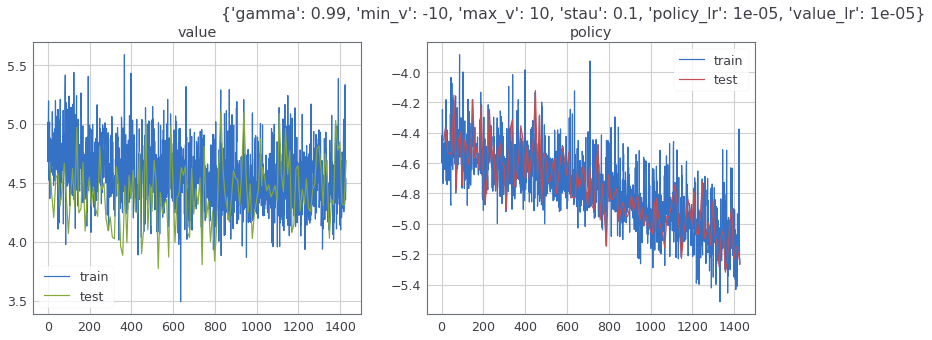

KeyboardInterrupt: 

In [204]:
def prepare_batch(batch):
    
    movies, ratings, done = batch
    movies, ratings, done = [torch.tensor(i.astype('float32')) for i in [movies, ratings, done]]
    movies_tensor = torch.stack([torch.stack([movie_ref[int(i)] for i in ts]) for ts in movies])
    batch_size = done.size(0)
    
    state = torch.cat([movies_tensor[:, :-1, :].view(batch_size, -1), ratings[:, :-1]], 1)
    next_state = torch.cat([movies_tensor[:, 1:, :].view(batch_size, -1), ratings[:, 1:]], 1)
    action = movies_tensor[:, -1]
    reward = ratings[:, -1]
    
    return [i.to(cuda) for i in [state, action, reward, next_state, done]]

# --- config ---
DEBUG = True

batch = []
plot_every = 10
min_policy_state_dict = None
min_policy_loss = 1
# --- end ---

for epoch in range(n_epochs):
    epoch_bar.update(1)
    for i in range(n_batches-1):
        step += 1
        batch_bar.update(1)
        
        batch = [f[key][i*batch_size:(i+1)*batch_size] for key in
                 ['movies', 'ratings', 'done']]
        batch = prepare_batch(batch)
        loss = ddpg_update(batch, debug=DEBUG, gamma = P_gamma, min_value=P_min_value,
                           max_value=P_max_value, soft_tau=P_soft_tau, step=step)
        
        value_losses.append(loss[0])
        policy_losses.append(loss[1])
        
        batch = []
        
        # debug plotting
        if step % plot_every == 0:
            clear_output(True)
            
            print('step', step)
            #if debug_test_gen_action is not None:
            # embed_show(debug_test_gen_action[:50])
            # embed_show(debug_gen_action[:50])
            plot(value_losses, policy_losses, cfg=P_cfg)
            
    batch_bar.refresh()

In [211]:
# torch.save(value_net.state_dict(), "../models/ddpg_value(Adam tuned).pt")
# torch.save(policy_net.state_dict(), "../models/ddpg_policy(Adam tuned).pt")

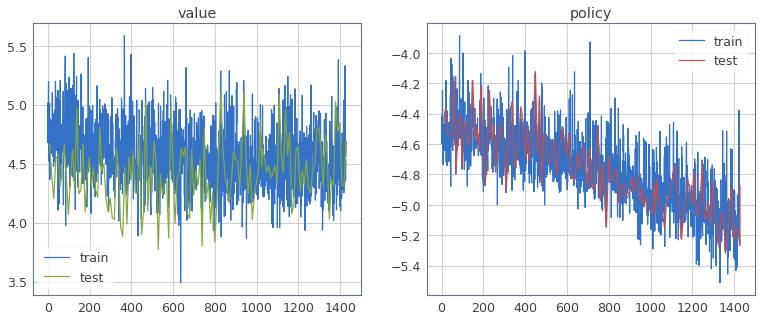

In [206]:
plot(value_losses, policy_losses)

# Debug info

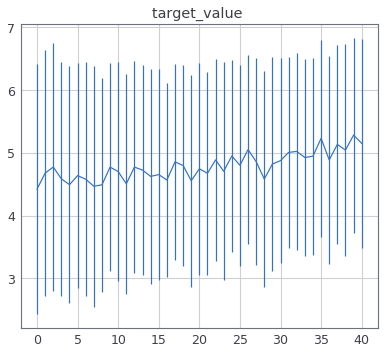

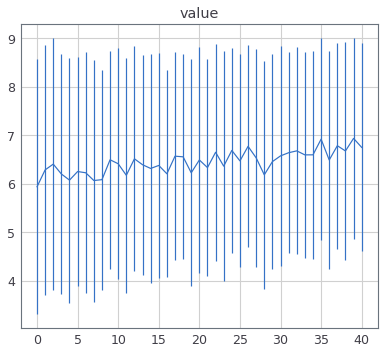

In [207]:
for key, error in debug_dict['error'].items():
    sf = int(np.sqrt(len(error['mean'])))
    plt.errorbar(range(len(error['mean'][::sf])), error['mean'][::sf], error['std'][::sf])
    plt.title(key)
    plt.show()

In [208]:
debug_gen_action[3]

tensor([-7.9848e-02,  2.2748e-01, -7.8747e-01,  1.2158e+00, -2.2335e+00,
        -1.9383e+00, -5.1301e-01, -1.0012e-01, -1.6681e-01, -4.3326e-01,
         1.0103e+00,  3.3123e-01,  1.6902e-01,  1.1395e+00, -5.0092e-01,
         9.0533e-01,  1.1820e+00, -2.1709e-01, -1.3490e-01,  1.0082e+00,
         3.2963e-01,  8.2983e-01, -3.0193e-01, -2.2864e+00,  1.4030e-01,
         2.7827e-01,  2.6930e-03, -5.5885e-01, -2.3566e-01,  9.0049e-01,
         6.4116e-01,  6.6554e-01,  5.3399e-01, -2.0956e+00, -4.6772e-01,
         6.4650e-01, -1.0958e-01,  3.8794e-01,  1.5079e-01,  2.1859e-01,
         6.8894e-01,  2.8801e-01, -1.1769e-01, -4.8968e-01, -1.9541e+00,
         8.4268e-03, -6.4964e-01, -6.6348e-01, -2.9449e-01, -8.3445e-01,
        -1.7788e-01,  5.2611e-01,  2.5087e-01, -1.0870e+00,  4.4034e-01,
        -7.4711e-01,  2.7541e-01,  1.3049e-01,  4.0544e-01,  1.3020e-01,
        -9.5563e-01,  1.6845e-01,  1.0703e+00,  1.5536e+00,  5.8708e-02,
        -4.3341e-01, -8.6511e-01,  4.1508e-01, -5.4

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


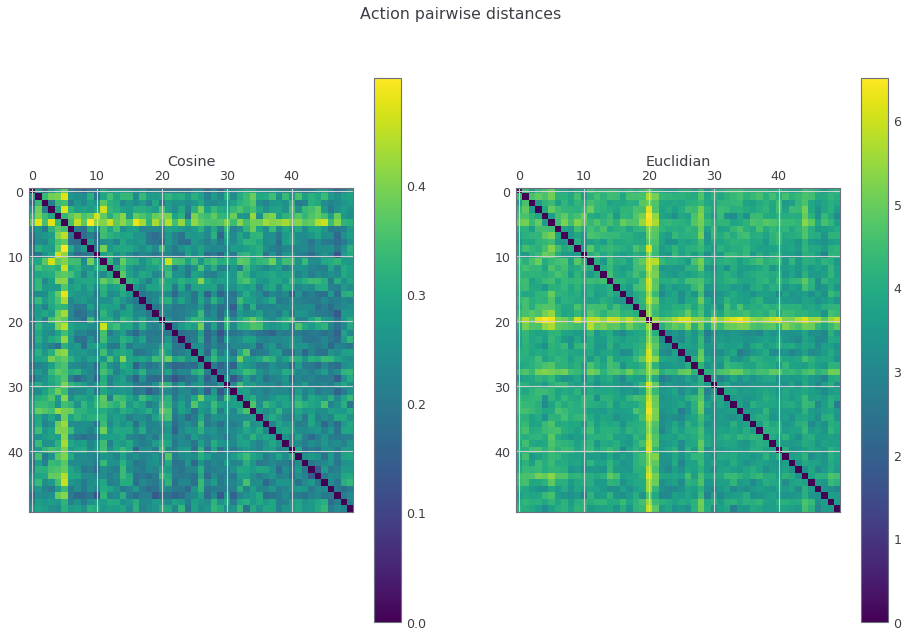

In [209]:
embed_show(debug_test_gen_action[:50])

# Reconstruction error

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


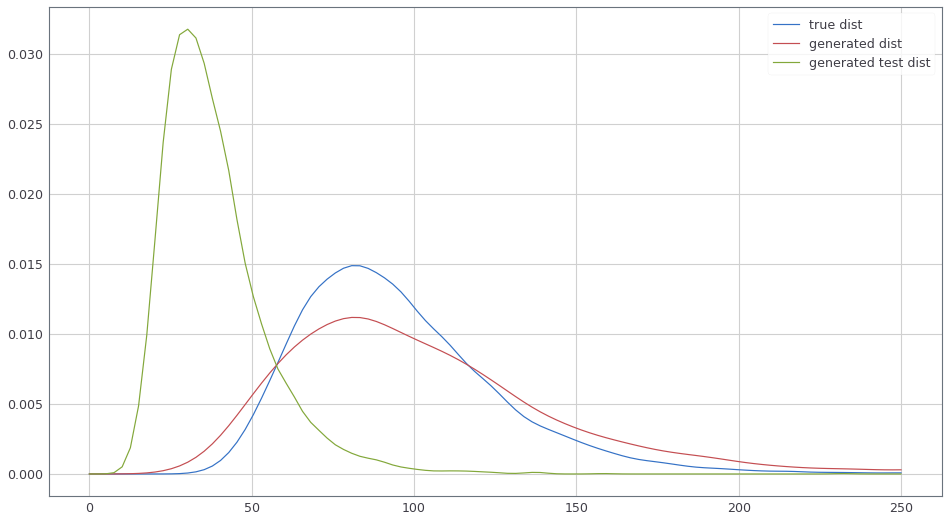

In [210]:

from scipy.special import kl_div
gen_actions = debug_gen_action
gen_test_actions = debug_test_gen_action
true_actions = np.stack([movie_ref[i] for i in movie_ref])


class AnomalyDetector(nn.Module):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.ae = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.ae(x)
    
    def rec_error(self, x):
        error = torch.sum((x - self.ae(x)) ** 2, 1)
        if x.size(1) != 1:
            return error.detach()
        return error.item()
    
ad = AnomalyDetector().to(cuda)
ad.load_state_dict(torch.load('../models/anomaly.pt'))
ad.eval()

from scipy import stats


true_scores = ad.rec_error(torch.tensor(true_actions).to(cuda).float()).detach().cpu().numpy()
gen_scores = ad.rec_error(torch.tensor(gen_actions).to(cuda).float()).detach().cpu().numpy()
gen_test_scores =ad.rec_error(torch.tensor(gen_test_actions).to(cuda).float()) \
                                                            .detach().cpu().numpy() 

true_kernel = stats.gaussian_kde(true_scores)
gen_kernel = stats.gaussian_kde(gen_scores)
gen_test_kernel = stats.gaussian_kde(gen_test_scores)

x = np.linspace(0,250, 100)
probs_true = true_kernel(x)
probs_gen = gen_kernel(x)
probs_gen_test = gen_test_kernel(x)
plt.figure(figsize=(16, 9))
plt.plot(x, probs_true, '-b', label='true dist')
plt.plot(x, probs_gen, '-r', label='generated dist')
plt.plot(x, probs_gen_test, '-g', label='generated test dist')
plt.legend()
plt.show()